In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader,random_split,Dataset,ConcatDataset
import torchvision
from torchvision.datasets import DTD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
import torchvision.transforms.functional as F_transforms
import os
import csv
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
!pip install pytorch-metric-learning
import torch.backends.cudnn as cudnn
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass


# **Drive Bağlantısı**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Paths**

In [3]:
folder="/content/drive/MyDrive/OODawareSupCon"
os.makedirs(folder, exist_ok=True)

In [4]:
result_dir_name = 'Results'
result_dir = os.path.join(folder, result_dir_name)
os.makedirs(result_dir, exist_ok=True)

In [5]:
checkpoint_dir_name = 'checkpoints'
checkpoint_dir = os.path.join(folder, checkpoint_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
data_dir_name='data'
data_dir = os.path.join(folder, data_dir_name)
os.makedirs(data_dir, exist_ok=True)

# **Import Data**

In [7]:
class twoCropTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

if cifar10, mean and std : mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
if custom: mean "(0.4914, 0.4822, 0.4465)" \
  --std "(0.2675, 0.2565, 0.2761)

In [8]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

In [10]:
train_dataset = torchvision.datasets.CIFAR10( root=data_dir, train=True,download=True,transform =twoCropTransform(train_transforms))
test_dataset = torchvision.datasets.CIFAR10( root=data_dir, train=False,download=True,transform = test_transforms)
ood_train = DTD( root=data_dir, split="train",download=True,transform = test_transforms)
ood_test = DTD( root=data_dir, split="test",download=True,transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Optional, Tuple, List
import logging

logging.basicConfig(level=logging.INFO)

In [12]:
def stratified_split_dataset(dataset: Dataset, train_size: float = 0.8, random_state: int = None)-> Tuple[Dataset, Dataset]:
    if not hasattr(dataset, 'targets'):
        raise ValueError("Dataset must have 'targets' attribute for stratified splitting")

    if isinstance(dataset.targets, list):
        y = np.array(dataset.targets)
    else:
        y = dataset.targets.numpy()

    splitter = StratifiedShuffleSplit(
        n_splits=1,
        train_size=train_size,
        random_state=random_state
    )

    train_indices, val_indices = next(splitter.split(np.zeros(len(dataset)), y))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset, val_dataset

In [13]:
val_dataset,test_dataset=stratified_split_dataset(test_dataset,train_size=0.5)

# **Show Image**

Sample 1:
Label: 6


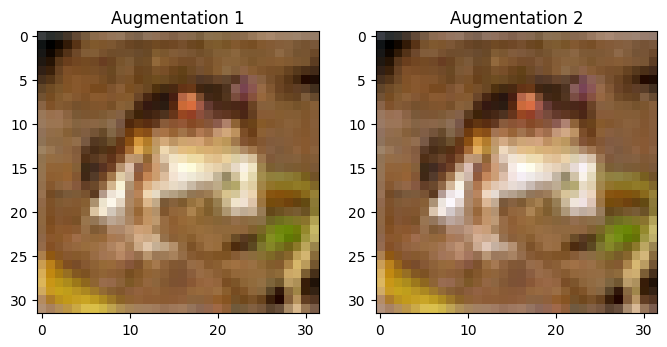

Sample 2:
Label: 9


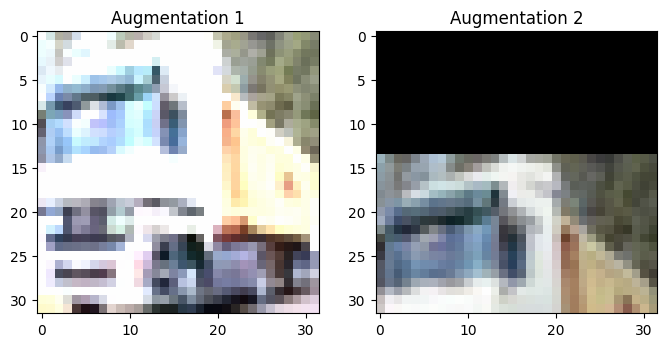

Sample 3:
Label: 9


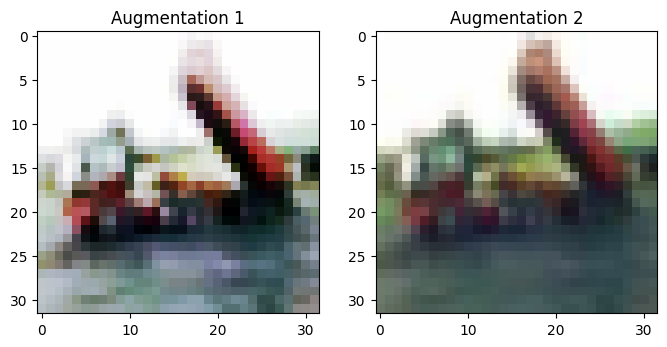

Sample 4:
Label: 4


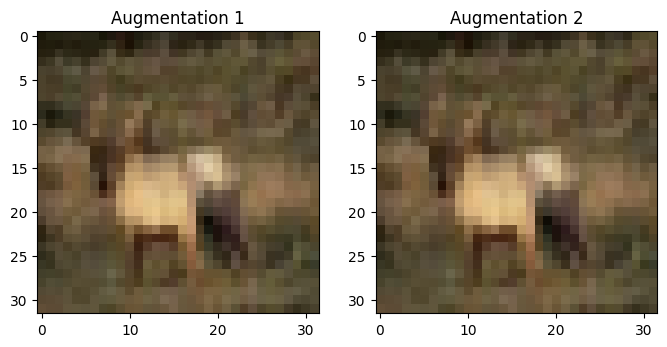

Sample 5:
Label: 1


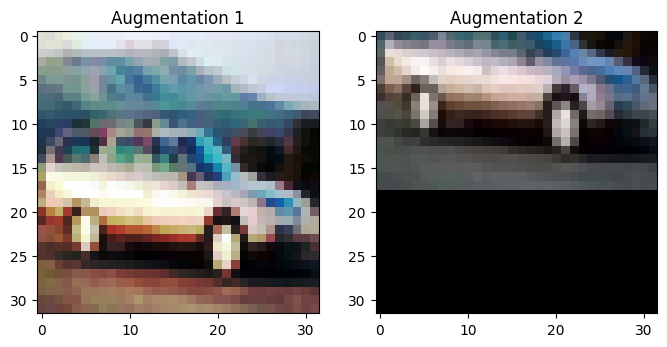

In [14]:
for i in range(5):
    images, label = train_dataset[i]

    print(f"Sample {i + 1}:")
    print(f"Label: {label}")

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(images[0].permute(1, 2, 0).numpy() *std + mean)
    axs[0].set_title("Augmentation 1")
    axs[1].imshow(images[1].permute(1, 2, 0).numpy() * std + mean)
    axs[1].set_title("Augmentation 2")

    plt.show()

Sample 101:
Label: 2


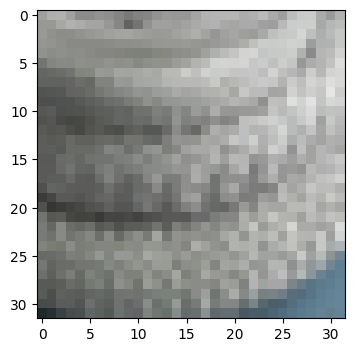

Sample 102:
Label: 2


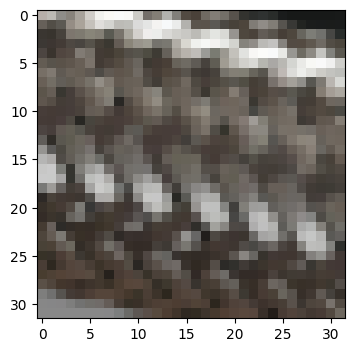

Sample 103:
Label: 2


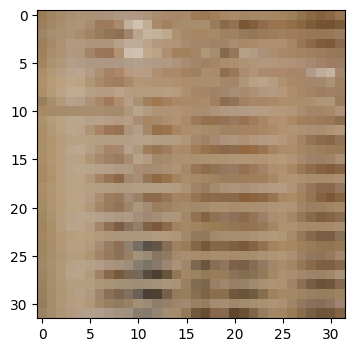

Sample 104:
Label: 2


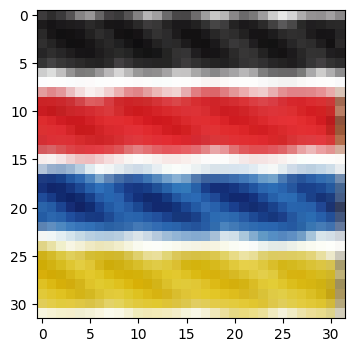

Sample 105:
Label: 2


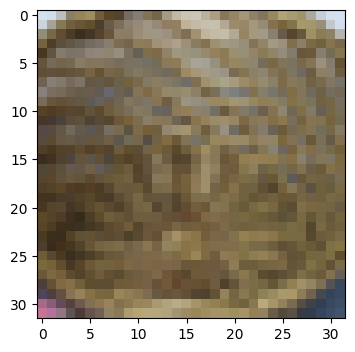

In [15]:
for i in range(100,105):
    image, label = ood_train[i]

    print(f"Sample {i + 1}:")
    print(f"Label: {label}")

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    axs.imshow(image.permute(1, 2, 0).numpy() * std + mean)

    plt.show()

# **Networks**

## *SupCon Network*

In [16]:
class SupConNet(nn.Module):
    def __init__(self, backbone, proj_dim=128, head_type="nonlinear"):
        super(SupConNet, self).__init__()
        self.stage="first"
        self.head_type = head_type
        self.encoder = backbone
        self.feature_dim = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()


        if self.head_type == 'nonlinear':
          self.projectionHead = nn.Sequential(
                                    nn.Linear(self.feature_dim,self.feature_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.feature_dim, proj_dim)
                              )
        elif self.head_type == 'linear':
          self.projectionHead = nn.Linear(self.feature_dim, proj_dim)



    def forward(self, x):
        features = self.encoder(x).squeeze()
        projections = self.projectionHead(features)
        projections = F.normalize(projections, dim=1)
        return features, projections



## *Classifier*

In [17]:
class LinearClassifier(nn.Module):
    def __init__(self, backbone, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.feature_dim = backbone.fc.in_features
        self.num_classes = num_classes
        self.fc = nn.Linear(self.feature_dim, self.num_classes, bias=False )

    def forward(self, features):
        x=self.fc(features)
        return x

    def initialize_prototypes(self, encoder, dataloader):
        feature_sums = torch.zeros(self.num_classes, self.feature_dim)
        class_counts = torch.zeros(self.num_classes)
        if torch.cuda.is_available():
            feature_sums = feature_sums.cuda()
            class_counts = class_counts.cuda()

        with torch.no_grad():
            for batch_data, batch_labels in dataloader:
                batch_data = batch_data[0]
                batch_labels = batch_labels
                if torch.cuda.is_available():
                    batch_data = batch_data.cuda()
                    batch_labels = batch_labels.cuda()
                features = encoder(batch_data)
                for cls in range(self.num_classes):
                    mask = (batch_labels == cls)
                    if mask.any():
                        feature_sums[cls] += features[mask].sum(dim=0)
                        class_counts[cls] += mask.sum()

            class_means = feature_sums / class_counts.unsqueeze(1)

            self.fc.weight.data = class_means

# **Losses**



## *SupCon loss*


In [18]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):

        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point.
        # Edge case e.g.:-
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan]
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

## *Tightness Loss*

In [19]:
class TightnessLossEncoder(nn.Module):
    def __init__(self):
        super(TightnessLossEncoder, self).__init__()

    def forward(self, features , prototypes , labels):
        features_norm = F.normalize(features, p=2, dim=1)
        prototypes = F.normalize(prototypes, p=2, dim=1)
        similarity = torch.sum(features_norm * prototypes[labels], dim=1)
        loss= -similarity.mean()
        return loss

## *Contrastive Encoder*

In [20]:
class ContrastiveLossEncoder(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLossEncoder, self).__init__()
        self.temperature = temperature

    def forward(self, ood_features, prototypes):
        ood_features = F.normalize(ood_features, p=2, dim=1)
        prototypes = F.normalize(prototypes, p=2, dim=1)
        similarities = torch.matmul(ood_features, prototypes.t()) / self.temperature

        lse = torch.logsumexp(similarities, dim=1)

        loss = lse.mean()

        return loss

## *Contrastive Projection Head*

In [21]:
class ContrastiveLossProjectionHead(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLossProjectionHead, self).__init__()
        self.temperature = temperature

    def forward(self, ood_projections, id_projections):

        similarities = torch.matmul(ood_projections, id_projections.t()) / self.temperature

        lse = torch.logsumexp(similarities, dim=1)

        loss = lse.mean()

        return loss

# **Utils**
## *Checkpoint*

In [22]:
def save_checkpoint(model, optimizer,scheduler, epoch, loss, checkpoint_dir,accuracy=None, filename='checkpoint_loss_range.pth'):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'accuracy':accuracy
    }, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')

In [39]:
def computeEmbeddings(loader, model, device, scaler=None):
    total_embeddings = np.zeros((len(loader)*loader.batch_size, 128))
    total_labels = np.zeros(len(loader)*loader.batch_size)
    model.eval()
    model.to(device)
    for idx, (images, labels) in enumerate(loader):
        if torch.cuda.is_available():
            images = images.cuda()
        bsz = labels.shape[0]
        if scaler:
            with torch.cuda.amp.autocast():
                _,embed = model(images)
                total_embeddings[idx * bsz: (idx + 1) * bsz] = embed.detach().cpu().numpy()
                total_labels[idx * bsz: (idx + 1) * bsz] = labels.detach().numpy()
        else:
            _,embed = model(images)
            total_embeddings[idx * bsz: (idx + 1) * bsz] = embed.detach().cpu().numpy()
            total_labels[idx * bsz: (idx + 1) * bsz] = labels.detach().numpy()

        del images, labels, embed
        torch.cuda.empty_cache()

    return np.float32(total_embeddings), total_labels.astype(int)

# **Device**

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Loops**

## *Train Loop*

In [25]:
def train(train_loader, model, criterion, optimizer, epoch=450):
    model.train()
    total_loss = 0

    for idx, (images, labels) in enumerate(train_loader, 1):
        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        bsz = labels.shape[0]

        _, zI = model(images)

        zI1, zI2 = torch.split(zI, [bsz, bsz], dim=0)

        zI = torch.cat([zI1.unsqueeze(1), zI2.unsqueeze(1)], dim=1)
        loss = criterion(zI, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 30 == 0:
            print(f'Train: [{epoch}][{idx}/{len(train_loader)}]\t Loss: {loss.item():.3f}\t Avg Loss: {total_loss / idx:.3f}')

    return total_loss / len(train_loader)


## *Fine Tune Loop*

In [26]:
def fine_tune(train_loader, trainOODLoader, model, classifier, criterion, tightness, contrastiveEnc, contrastiveProj, alpha, gamma, optimizer, epoch=50):
    model.train()
    classifier.train()
    total_loss = 0
    ood_iter = iter(trainOODLoader)
    for idx, (images, labels) in enumerate(train_loader, 1):
        try:
            imageOOD, labelsOOD = next(ood_iter)
        except StopIteration:
            ood_iter = iter(trainOODLoader)
            imageOOD, labelsOOD = next(ood_iter)

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            imageOOD = imageOOD.cuda()
        bsz = labels.shape[0]
        bszOOD = labelsOOD.shape[0]

        fI, zI = model(images)
        zI1, zI2 = torch.split(zI, [bsz, bsz], dim=0)
        zI = torch.cat([zI1.unsqueeze(1), zI2.unsqueeze(1)], dim=1)
        lossSupcon = criterion(zI, labels)

        fI1, _ = torch.split(fI, [bsz, bsz], dim=0)
        _ = classifier(fI1)
        pI = classifier.fc.weight
        lossTightness = tightness(fI1, pI, labels)


        fO, zO = model(imageOOD)

        lossContrastProj = contrastiveProj(zO, zI1)
        lossContrastEnc = contrastiveEnc(fO, pI)

        loss = lossSupcon + gamma * lossTightness + alpha * (lossContrastProj + lossContrastEnc)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        if idx % 30 == 0:
            print(f'Train: [{epoch}][{idx}/{len(train_loader)}]\t Loss: {loss.item():.3f}\t Avg Loss: {total_loss / idx:.3f}')

    return total_loss / len(train_loader)

# **Parameters**

In [27]:
parameters={
    "model":{
        "backbone":models.resnet18(pretrained=False),
        "proj_dim":128,
        "head_type":"nonlinear"
    },
    "classifier":{
        "backbone":models.resnet18(pretrained=False)
    },
    "optimizer":{
        "lr":2.5e-3,
        "momentum":0.9,
        "weight_decay":1e-4
    },
    "optimizer_classifier":{
        "momentum":0.9,
        "weight_decay":1e-4
    },
    "scheduler":{
        "T_max":10,
        "eta_min":1e-4
    },
    "supConLoss":{
        "temperature":0.07
    },
    "train_epoch":450,
    "fine_tune_epoch":50,
    "alpha":0.1,
    "gamma":1
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# **Main**

## *Data Loader*

In [28]:

train_loader = DataLoader(train_dataset,batch_size=512,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=512,shuffle=False)


ood_train_loader = DataLoader(ood_train, batch_size=512,shuffle=False)
ood_test_loader = DataLoader(ood_test, batch_size=512,shuffle=False)


## *Train*

In [29]:
#train
best_train_loss = float('inf')

model=SupConNet(**parameters["model"])
supconLost=SupConLoss(**parameters["supConLoss"])
model.to(device)
supconLost.to(device)






optimizer = torch.optim.SGD(model.parameters(),**parameters["optimizer"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **parameters["scheduler"])
train_losses = []
for epoch in range(1,parameters["train_epoch"]+1):

    loss = train(train_loader, model, supconLost, optimizer, epoch)
    train_losses.append(loss)
    scheduler.step()


    print(f'Epoch [{epoch}/450],    Learning Rate: {scheduler.get_last_lr()[0]:.4f},    Train Loss: {loss:.4f}')
    if loss < best_train_loss  :
        best_train_loss = loss
        save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='train_supcon_best_checkpoint.pth')

save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='train_supcon_last.pth')





Train: [1][30/98]	 Loss: 6.928	 Avg Loss: 6.991
Train: [1][60/98]	 Loss: 6.921	 Avg Loss: 6.957
Train: [1][90/98]	 Loss: 6.883	 Avg Loss: 6.939
Epoch [1/450],    Learning Rate: 0.0024,    Train Loss: 6.9313
Checkpoint saved at epoch 1 to /content/drive/MyDrive/OODawareSupCon/checkpoints/train_supcon_best_checkpoint.pth
Train: [2][30/98]	 Loss: 6.846	 Avg Loss: 6.868
Train: [2][60/98]	 Loss: 6.844	 Avg Loss: 6.854
Train: [2][90/98]	 Loss: 6.783	 Avg Loss: 6.840
Epoch [2/450],    Learning Rate: 0.0023,    Train Loss: 6.8323
Checkpoint saved at epoch 2 to /content/drive/MyDrive/OODawareSupCon/checkpoints/train_supcon_best_checkpoint.pth
Train: [3][30/98]	 Loss: 6.777	 Avg Loss: 6.788
Train: [3][60/98]	 Loss: 6.792	 Avg Loss: 6.779
Train: [3][90/98]	 Loss: 6.753	 Avg Loss: 6.775
Epoch [3/450],    Learning Rate: 0.0020,    Train Loss: 6.7694
Checkpoint saved at epoch 3 to /content/drive/MyDrive/OODawareSupCon/checkpoints/train_supcon_best_checkpoint.pth
Train: [4][30/98]	 Loss: 6.754	 Avg L

AttributeError: 'float' object has no attribute 'item'

Loss values saved to /content/drive/MyDrive/OODawareSupCon/Results/train_losses.csv


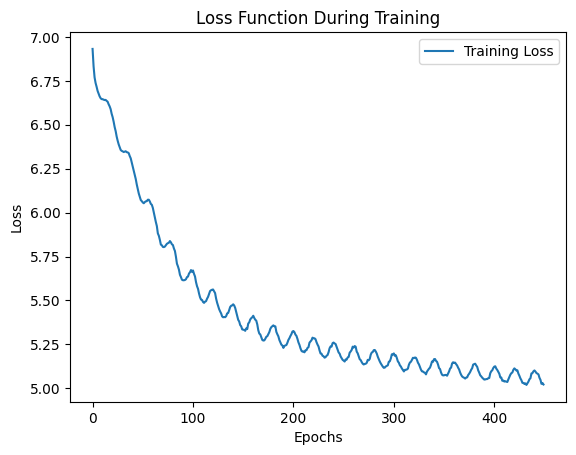

Loss plot saved to /content/drive/MyDrive/OODawareSupCon/Results/loss_plot.png


In [32]:
csv_path = os.path.join(result_dir, 'train_losses.csv')

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss'])
    for epoch, loss in enumerate(train_losses, 1):
        writer.writerow([epoch, loss])

print(f"Loss values saved to {csv_path}")


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function During Training')
plt.legend()

png_path = os.path.join(result_dir, 'loss_plot.png')

plt.savefig(png_path)


plt.show()
print(f"Loss plot saved to {png_path}")

## *Fine Tune*

In [34]:
#Fine Tune
best_fine_tune_loss = float('inf')
tightnessLoss=TightnessLossEncoder().to(device)
contEnc=ContrastiveLossEncoder().to(device)
contProj=ContrastiveLossProjectionHead().to(device)

classifier= LinearClassifier(**parameters["classifier"])
classifier.to(device)


classifier.initialize_prototypes(model.encoder,train_loader)

optimizer = torch.optim.SGD([
    {'params': model.parameters(), 'lr': 2.5e-3},
    {'params': classifier.parameters(), 'lr': 0.01} ], **parameters["optimizer_classifier"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **parameters["scheduler"])
fine_tuning_losses = []
for epoch in range(1,parameters["fine_tune_epoch"]+1):
    loss = fine_tune(train_loader,ood_train_loader, model, classifier, supconLost,tightnessLoss,contEnc,contProj,parameters["alpha"],parameters["gamma"], optimizer,epoch)
    fine_tuning_losses.append(loss)
    scheduler.step()


    print(f'Epoch [{epoch}/50],    Learning Rate: {scheduler.get_last_lr()[0]:.4f},    Train Loss: {loss:.4f}')
    if loss < best_fine_tune_loss  :
        best_fine_tune_loss = loss
        save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='fine_tune_supcon_best_checkpoint.pth')
        save_checkpoint(model=classifier,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='classifier_supcon_best_checkpoint.pth')
save_checkpoint(model=model,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='fine_supcon_tune_last.pth')
save_checkpoint(model=classifier,optimizer= optimizer,scheduler= scheduler,epoch= epoch,loss= loss,checkpoint_dir= checkpoint_dir,filename='classifier_supcon_last_checkpoint.pth')




Train: [1][30/98]	 Loss: 6.558	 Avg Loss: 6.441
Train: [1][60/98]	 Loss: 6.430	 Avg Loss: 6.452
Train: [1][90/98]	 Loss: 6.552	 Avg Loss: 6.465
Epoch [1/50],    Learning Rate: 0.0024,    Train Loss: 6.4606
Checkpoint saved at epoch 1 to /content/drive/MyDrive/OODawareSupCon/checkpoints/fine_tune_supcon_best_checkpoint.pth
Checkpoint saved at epoch 1 to /content/drive/MyDrive/OODawareSupCon/checkpoints/classifier_supcon_best_checkpoint.pth
Train: [2][30/98]	 Loss: 6.402	 Avg Loss: 6.434
Train: [2][60/98]	 Loss: 6.199	 Avg Loss: 6.365
Train: [2][90/98]	 Loss: 6.785	 Avg Loss: 6.392
Epoch [2/50],    Learning Rate: 0.0023,    Train Loss: 6.4160
Checkpoint saved at epoch 2 to /content/drive/MyDrive/OODawareSupCon/checkpoints/fine_tune_supcon_best_checkpoint.pth
Checkpoint saved at epoch 2 to /content/drive/MyDrive/OODawareSupCon/checkpoints/classifier_supcon_best_checkpoint.pth
Train: [3][30/98]	 Loss: 6.792	 Avg Loss: 6.767
Train: [3][60/98]	 Loss: 6.477	 Avg Loss: 6.789
Train: [3][90/98]	

Loss values saved to /content/drive/MyDrive/OODawareSupCon/Results/fine_tuning_losses.csv


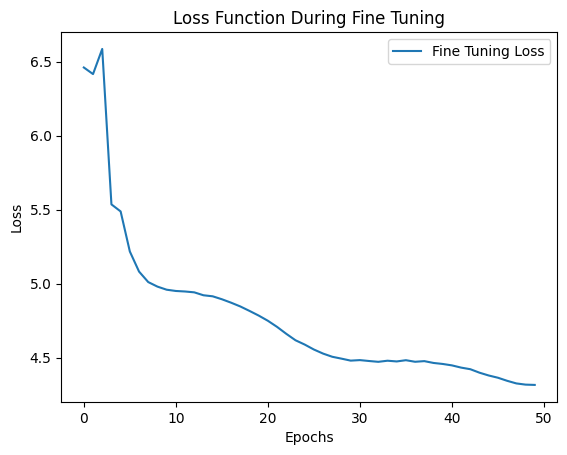

Loss plot saved to /content/drive/MyDrive/OODawareSupCon/Results/fine_tuning_losses_plot.png


In [35]:
csv_path = os.path.join(result_dir, 'fine_tuning_losses.csv')

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss'])
    for epoch, loss in enumerate(fine_tuning_losses, 1):
        writer.writerow([epoch, loss])

print(f"Loss values saved to {csv_path}")


plt.plot(fine_tuning_losses, label='Fine Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function During Fine Tuning')
plt.legend()

png_path = os.path.join(result_dir, 'fine_tuning_losses_plot.png')

plt.savefig(png_path)


plt.show()
print(f"Loss plot saved to {png_path}")

## *T-SNE*

<ipython-input-40-8556e37c9f04>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-40-8556e37c9f04>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

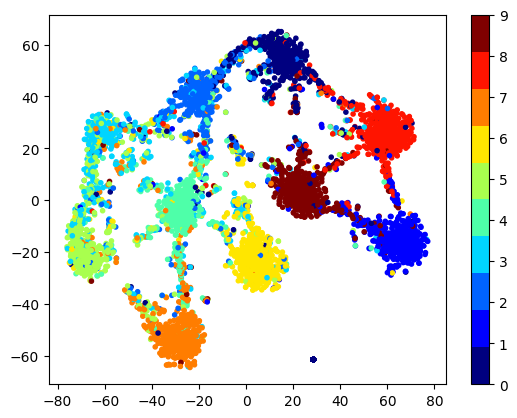

In [40]:


scaler = torch.cuda.amp.GradScaler()

model_tsne=SupConNet(backbone=models.resnet18(pretrained=False))
checkpoint=torch.load(os.path.join(checkpoint_dir,"train_supcon_best_checkpoint.pth"))
model_tsne.load_state_dict(checkpoint["model_state_dict"])
embeddings,labels=computeEmbeddings(val_loader, model_tsne, device, scaler)
embeddings_tsne = TSNE(n_jobs=10).fit_transform(embeddings)
vis_x = embeddings_tsne[:, 0]
vis_y = embeddings_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()


<ipython-input-41-f538bf7fba30>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-41-f538bf7fba30>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See ht

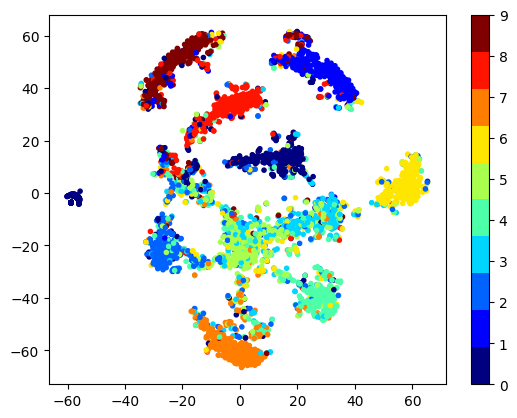

In [41]:


scaler = torch.cuda.amp.GradScaler()

model_tsne=SupConNet(backbone=models.resnet18(pretrained=False))
checkpoint=torch.load(os.path.join(checkpoint_dir,"fine_tune_supcon_best_checkpoint.pth"))
model_tsne.load_state_dict(checkpoint["model_state_dict"])
embeddings,labels=computeEmbeddings(val_loader, model_tsne, device, scaler)
embeddings_tsne = TSNE(n_jobs=10).fit_transform(embeddings)
vis_x = embeddings_tsne[:, 0]
vis_y = embeddings_tsne[:, 1]
plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.show()
